## -------------------------- RESUME CLASSIFICATION ---------------------------------

#### Business objective: The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention...

### Loading data(Resumes) and Installing required libraries 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# importing some required libraries
import numpy as np
import os
import pandas as pd
import pdfplumber
from docx import Document
import win32com.client as win32

In [5]:
# 1. CONFIGURATION
base_dataset_folder = r"C:\Users\dongr\OneDrive\Desktop\Resume Classification\Resumes"

# 2. HELPER FUNCTIONS (To read different formats)
def extract_text_from_docx(file_path):
    text = ""
    try:
        doc = Document(file_path)
        for para in doc.paragraphs:
            text += para.text + "\n"
    except: pass
    return text

def extract_text_from_pdf(file_path):
    text = ""
    try:
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                t = page.extract_text()
                if t: text += t + "\n"
    except: pass
    return text

def extract_text_from_doc(file_path, word_app):
    text = ""
    try:
        # Open .doc file in background
        doc = word_app.Documents.Open(file_path)
        text = doc.Content.Text
        doc.Close(False)
    except: pass
    return text

# 3. MAIN PROCESS

records = []
try:
    # Open Word App in background for .doc files
    word_app = win32.Dispatch("Word.Application")
    word_app.Visible = False
except:
    word_app = None
    print("Warning: Could not open MS Word. Old .doc files might be skipped.")

print("Processing resumes... Please wait...")

for root, dirs, files in os.walk(base_dataset_folder):
    
    # DETERMINE CATEGORY
    if root == base_dataset_folder:
        continue
    else:
        # Otherwise, use the folder name (e.g., "Peoplesoft resumes")
        category = os.path.basename(root)

    for filename in files:
        file_path = os.path.join(root, filename)
        content = ""
        ext = filename.lower()
        
        # EXTRACT CONTENT BASED ON TYPE
        if ext.endswith('.docx'):
            content = extract_text_from_docx(file_path)
        elif ext.endswith('.pdf'):
            content = extract_text_from_pdf(file_path)    
        elif ext.endswith('.doc'):
            if word_app:
                content = extract_text_from_doc(file_path, word_app)
        
        # SAVE DATA
        if content and content.strip():
            records.append({
                'Category': category,
                'Name': filename, # Keeping filename helps you check if it worked
                'Content': content.strip()
            })

# Cleanup Word App
if word_app:
    word_app.Quit()

# Create DataFrame
df = pd.DataFrame(records)

# 4. RESULTS

print("\n" + "="*71)
print(f"Total Resumes Processed: {len(df)}")
print(f"Categories Found: {df['Category'].unique()}")
print("="*71)

Processing resumes... Please wait...

Total Resumes Processed: 79
Categories Found: ['Peoplesoft resumes' 'React Developer resumes'
 'SQL Developer Lightning insight' 'workday resumes']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  79 non-null     object
 1   Name      79 non-null     object
 2   Content   79 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [7]:
df.shape

(79, 3)

In [8]:
df.head()

,Category,Name,Content
0,Peoplesoft resumes,Peoplesoft Admin_AnubhavSingh.docx,Anubhav Kumar Singh\t\t\n\n To work in a glob...
1,Peoplesoft resumes,Peoplesoft Admin_G Ananda Rayudu.doc,Profile Summary:\t\t\t\t\t\t\t\t\t\t\r7+ years...
2,Peoplesoft resumes,Peoplesoft Admin_Gangareddy.doc,PeopleSoft Database Administrator\r ...
3,Peoplesoft resumes,Peoplesoft Admin_Murali.docx,Murali\n\nExperience Summary \n\nI have 6 year...
4,Peoplesoft resumes,Peoplesoft Admin_Priyanka Ramadoss.doc,"Priyanka Ramadoss\r61/46, MountPleasant, \rCoo..."


In [9]:
df.tail()

,Category,Name,Content
74,workday resumes,Sri Krishna S_Hexaware.doc,Workday Integration Consultant\r\rName ...
75,workday resumes,Srikanth-Hexaware.docx,Seeking suitable positions in Workday HCM as ...
76,workday resumes,SSKumar_Hexaware.docx,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...
77,workday resumes,Venkateswarlu B_Hexaware.doc,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...
78,workday resumes,Vinay Kumar_Hexaware.docx,Vinay kumar .v\nWorkday Functional Consultant\...


In [10]:
df.describe()

,Category,Name,Content
count,79,79,79
unique,4,79,79
top,React Developer resumes,Peoplesoft Admin_AnubhavSingh.docx,Anubhav Kumar Singh\t\t\n\n To work in a glob...
freq,24,1,1


### Data Preproccesing

Raw text from PDFs and Word docs is usually "noisy." It has weird symbols, huge gaps, website links, and email addresses that might confuse our model. We need to strip that out so the model focuses only on the important keywords (skills, experience, etc..)

In [13]:
import re

def clean_resume_text(text):
    # 1. Convert to lower case (so "Python" and "python" are the same)
    text = text.lower()
    
    # 2. Remove URLs (http/https/www)
    text = re.sub('http\S+\s*', ' ', text)
    text = re.sub('www\S+\s*', ' ', text)
    
    # 3. Remove Emails (candidate emails don't help predict the category)
    text = re.sub('\S+@\S+', ' ', text)
    
    # 4. Remove Special Characters (keep only letters, numbers, and # or + for skills like C++ or C#)
    # This regex allows a-z, A-Z, 0-9, #, and +
    text = re.sub(r'[^a-zA-Z0-9#\+\s]', '', text)
    
    # 5. Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the function to DataFrame
print("Cleaning text... this might take a second.")
df['Cleaned_Content'] = df['Content'].apply(clean_resume_text)

# Check the difference
print("Cleaning Complete!")
print("\n------------------- Original Raw Text (First 200 chars) -----------------")
print(df['Content'].iloc[0][:200])

print("\n------------------- Cleaned Text (First 200 chars) ----------------------")
print(df['Cleaned_Content'].iloc[0][:200])

Cleaning text... this might take a second.
Cleaning Complete!

------------------- Original Raw Text (First 200 chars) -----------------
Anubhav Kumar Singh		

  To work in a globally competitive environment on 
  challenging assignments that shall yield the 
  twin benefits of the job satisfaction and a steady-paced 
  professional gr

------------------- Cleaned Text (First 200 chars) ----------------------
anubhav kumar singh to work in a globally competitive environment on challenging assignments that shall yield the twin benefits of the job satisfaction and a steadypaced professional growth profession


In [14]:
from sklearn.feature_extraction import text  # <--- THIS WAS MISSING
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Create a Custom List of "Resume Fluff" to ignore
# These are words that appear in almost every resume and confuse the model
my_stop_words = list(text.ENGLISH_STOP_WORDS.union([
    "experience", "worked", "working", "work", "job", "career",
    "project", "projects", "role", "responsibilities", "description",
    "team", "member", "involved", "application", "app", "used", "using",
    "client", "company", "services", "technologies", "technology", "tool", "tools",
    "summary", "profile", "professional", "year", "years", "month", "months",
    "contact", "mobile", "email", "address", "phone", "date", "education",
    "university", "college", "school", "degree", "bachelor", "master"
]))

print(f"🚫 Banning {len(my_stop_words)} generic resume words.")

# 2. Update Vectorizer with Strict Rules
tfidf = TfidfVectorizer(
    stop_words=my_stop_words,  # <--- Apply the Ban List
    max_features=3000,
    ngram_range=(1, 2),        # Keep looking at pairs (e.g., "SQL Server")
    max_df=0.85,               # Ignore words that appear in >85% of all resumes
    min_df=2                   # Ignore words that appear in only 1 resume
)

print("🧹 Re-cleaning and Vectorizing...")
X = tfidf.fit_transform(df['Cleaned_Content'])

print(f"✅ New Feature Matrix: {X.shape}")
print("   (Generic words are now gone!)")

🚫 Banning 363 generic resume words.
🧹 Re-cleaning and Vectorizing...
✅ New Feature Matrix: (79, 3000)
   (Generic words are now gone!)


In [15]:
# ==========================================
# UPDATED FEATURE ENGINEERING
# ==========================================
from sklearn.feature_extraction.text import TfidfVectorizer

print("🧹 Cleaning Data...")
df['Cleaned_Content'] = df['Content'].apply(clean_resume_text)

print("🔠 Vectorizing with N-Grams (1 to 2 words)...")

# IMPROVEMENT: We now look for Unigrams (1 word) AND Bigrams (2 words)
# This captures "Machine Learning", "SQL Server", "React JS" as distinct features
tfidf = TfidfVectorizer(
    stop_words='english', 
    max_features=4000,      # Cap features to prevent overfitting
    ngram_range=(1, 2),     
    sublinear_tf=True       # Logarithmic scaling (helps dampen the effect of very frequent words)
)

required_vectors = tfidf.fit_transform(df['Cleaned_Content'])

print(f"✅ Feature Matrix Shape: {required_vectors.shape}")
print("   (Rows = Resumes, Columns = Unique Word Patterns)")

🧹 Cleaning Data...
🔠 Vectorizing with N-Grams (1 to 2 words)...
✅ Feature Matrix Shape: (79, 4000)
   (Rows = Resumes, Columns = Unique Word Patterns)


In [16]:
# Final Check of the DataFrame
df.head()

,Category,Name,Content,Cleaned_Content
0,Peoplesoft resumes,Peoplesoft Admin_AnubhavSingh.docx,Anubhav Kumar Singh\t\t\n\n To work in a glob...,anubhav kumar singh to work in a globally comp...
1,Peoplesoft resumes,Peoplesoft Admin_G Ananda Rayudu.doc,Profile Summary:\t\t\t\t\t\t\t\t\t\t\r7+ years...,profile summary 7+ years of experience in impl...
2,Peoplesoft resumes,Peoplesoft Admin_Gangareddy.doc,PeopleSoft Database Administrator\r ...,peoplesoft database administrator gangareddy p...
3,Peoplesoft resumes,Peoplesoft Admin_Murali.docx,Murali\n\nExperience Summary \n\nI have 6 year...,murali experience summary i have 6 years of ex...
4,Peoplesoft resumes,Peoplesoft Admin_Priyanka Ramadoss.doc,"Priyanka Ramadoss\r61/46, MountPleasant, \rCoo...",priyanka ramadoss 6146 mountpleasant coonoor t...


In [17]:
# Saving to CSV
df.to_csv('cleaned_resume_data.csv', index=False)
print("File saved successfully as 'cleaned_resume_data.csv'")

File saved successfully as 'cleaned_resume_data.csv'


### Feature Engineering

#### Label Encoding (Converting Categories to Numbers)

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
le = LabelEncoder() # Initializing the encoder
df['Category_ID'] = le.fit_transform(df['Category']) # Fit and transform the 'Category' column
# Display the mapping so you know which number is which category
print("Category Mapping:")
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(category_mapping)

Category Mapping:
{'Peoplesoft resumes': 0, 'React Developer resumes': 1, 'SQL Developer Lightning insight': 2, 'workday resumes': 3}


#### Vectorization (Converting Text to Numbers using TF-IDF)

In [23]:
# TF-IDF helps us find important words (like 'React', 'SQL') while ignoring common words (like 'the', 'and')
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
# Fit and transform the cleaned text
# This creates a large matrix of numbers
required_text = df['Cleaned_Content'].values
required_vectors = tfidf.fit_transform(required_text)

print("\nVectorization Complete!")
print(f"Shape of Data (Rows, Features): {required_vectors.shape}")


Vectorization Complete!
Shape of Data (Rows, Features): (79, 4987)


### Exploratory Data Analysis (EDA)

In [25]:
# importing basic libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a nice style for the plots
sns.set_style("whitegrid")

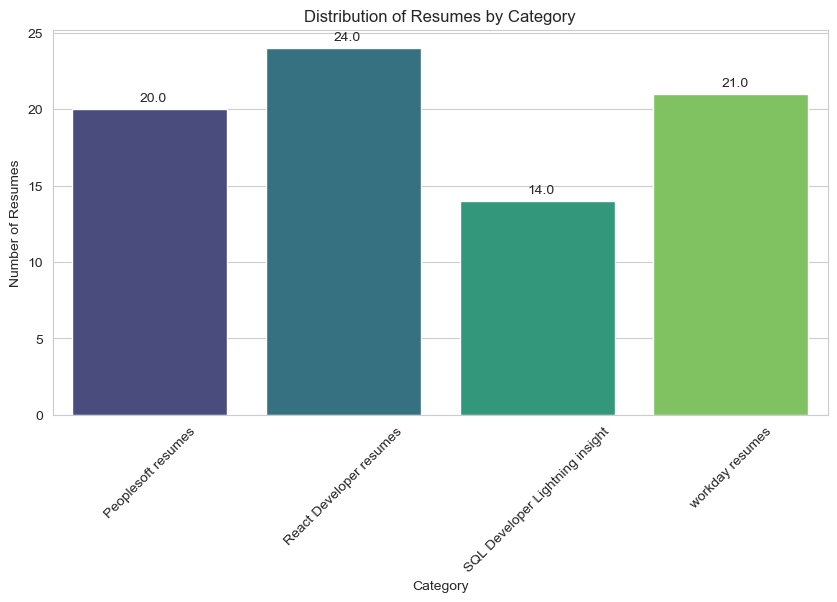

In [26]:
# VISUALIZATION OF CATEGORY DISTRIBUTION

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Distribution of Resumes by Category')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=45)

# Add count numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 0.5))
plt.show()

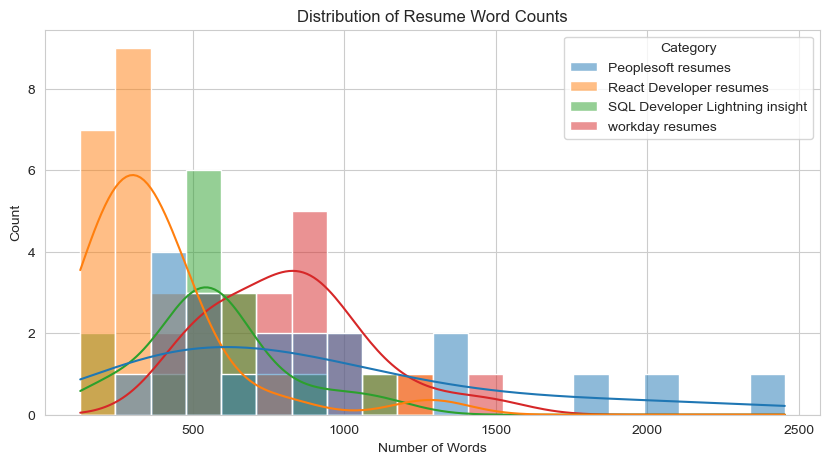

In [27]:
# VISUALIZATION OF RESUME LENGTH (Word Count)
# CreatING a temporary column for word count
df['Word_Count'] = df['Cleaned_Content'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Word_Count', hue='Category', kde=True, bins=20)
plt.title('Distribution of Resume Word Counts')
plt.xlabel('Number of Words')
plt.show()


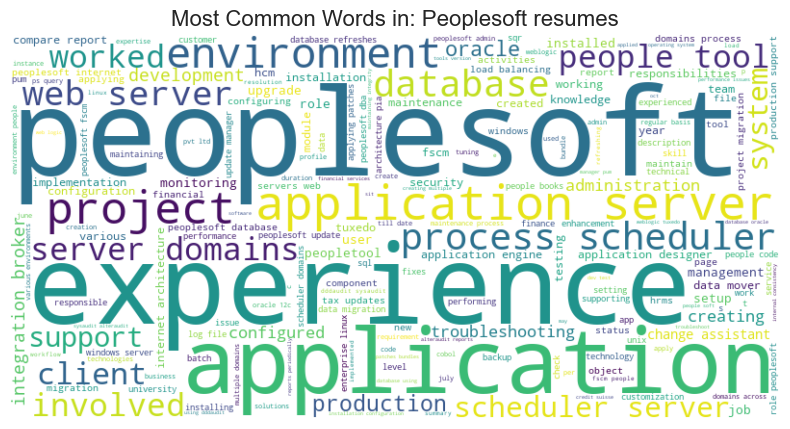

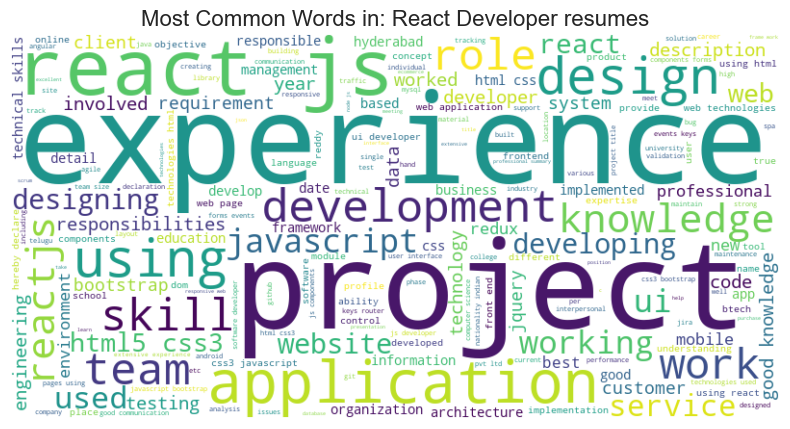

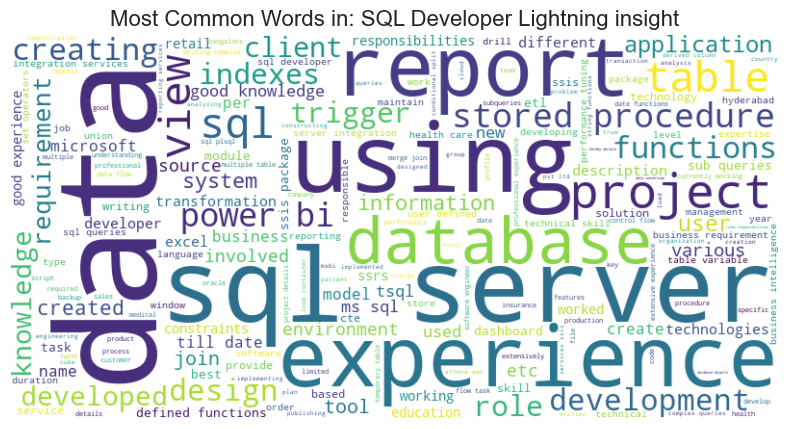

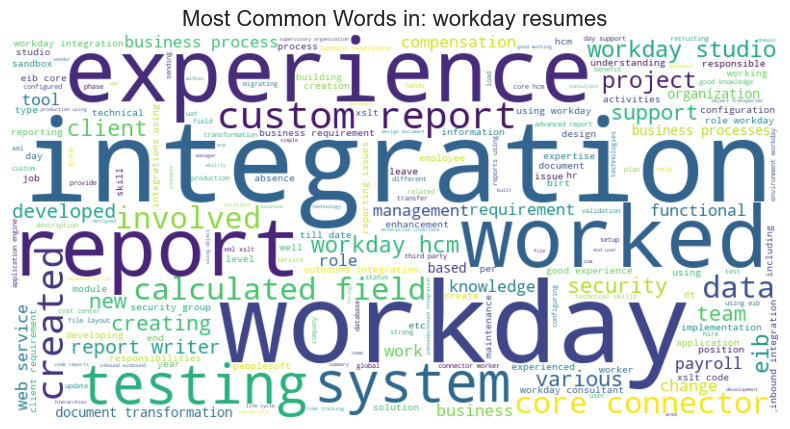

In [28]:
# 3. WORD CLOUD (Most Frequent Words)
# We will generate a separate word cloud for each category
categories = df['Category'].unique()

for cat in categories:
    # Filter text for just this category
    cat_text = " ".join(df[df['Category'] == cat]['Cleaned_Content'])
    
    # Generate WordCloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(cat_text)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Common Words in: {cat}", fontsize=16)
    plt.show()

This visulaizations says that the biggest words proves our data cleaning worked perfectly. The model will easily pick up on these signals.

##### Bigram Analysis (Top 2-Word Phrases)

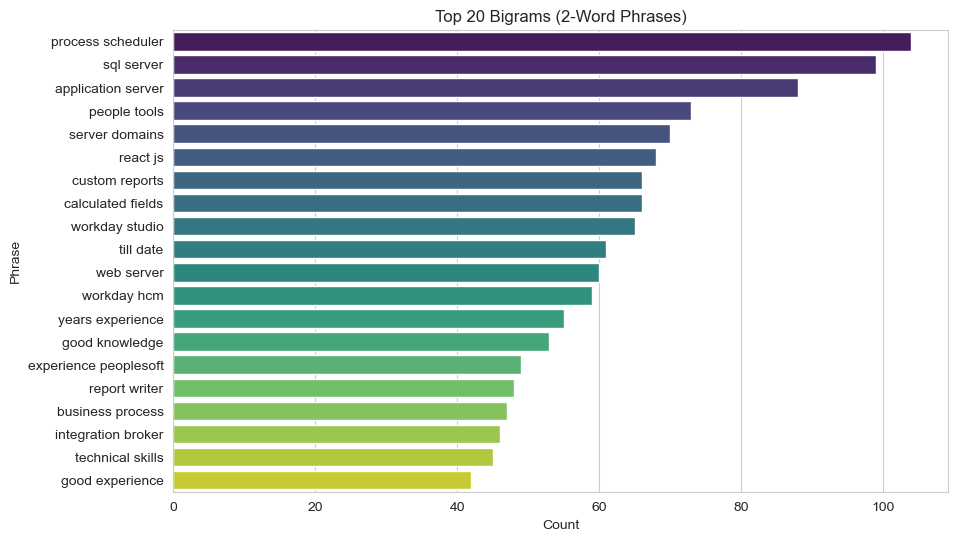

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_n_grams(text_data, ngram_range=(2, 2), top_n=20):
    # Create a vectorizer that looks for pairs of words (2,2)
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text_data)
    bag_of_words = vec.transform(text_data)
    
    # Sum up the counts of each phrase
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Sort them
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:top_n]
    
    # Prepare data for plotting
    df_ngram = pd.DataFrame(common_words, columns = ['Phrase', 'Count'])
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Phrase', data=df_ngram, palette='viridis')
    plt.title(f'Top {top_n} Bigrams (2-Word Phrases)')
    plt.show()

# Run the function on your cleaned content
plot_n_grams(df['Cleaned_Content'])

Here we see the top 20 most common "two-word phrases" across all resumes.
This Bigram chart is incredibly revealing! It shows clear technical clusters: "process scheduler" (likely PeopleSoft), "sql server", and "workday studio". This confirms our data has very strong, distinguishable signals.

##### Heatmap

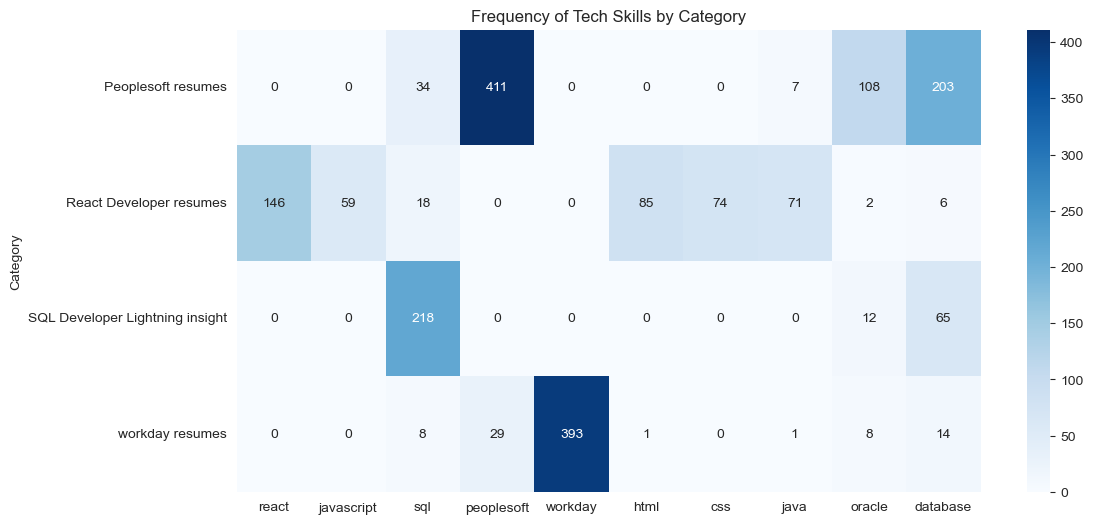

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define a list of specific skills you want to check
# You can add more skills to this list!
target_skills = ['react', 'javascript', 'sql', 'peoplesoft', 'workday', 'html', 'css', 'java', 'oracle', 'database']

# 2. Count mentions of each skill per category
skill_counts = []

for category in df['Category'].unique():
    # Get all text for this category
    cat_text = " ".join(df[df['Category'] == category]['Cleaned_Content'])
    
    # Count occurrences of each specific skill
    counts = {skill: cat_text.count(skill) for skill in target_skills}
    counts['Category'] = category
    skill_counts.append(counts)

# 3. Create a DataFrame for plotting
df_skills = pd.DataFrame(skill_counts).set_index('Category')

# 4. Plot the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_skills, annot=True, cmap='Blues', fmt='d')
plt.title('Frequency of Tech Skills by Category')
plt.show()

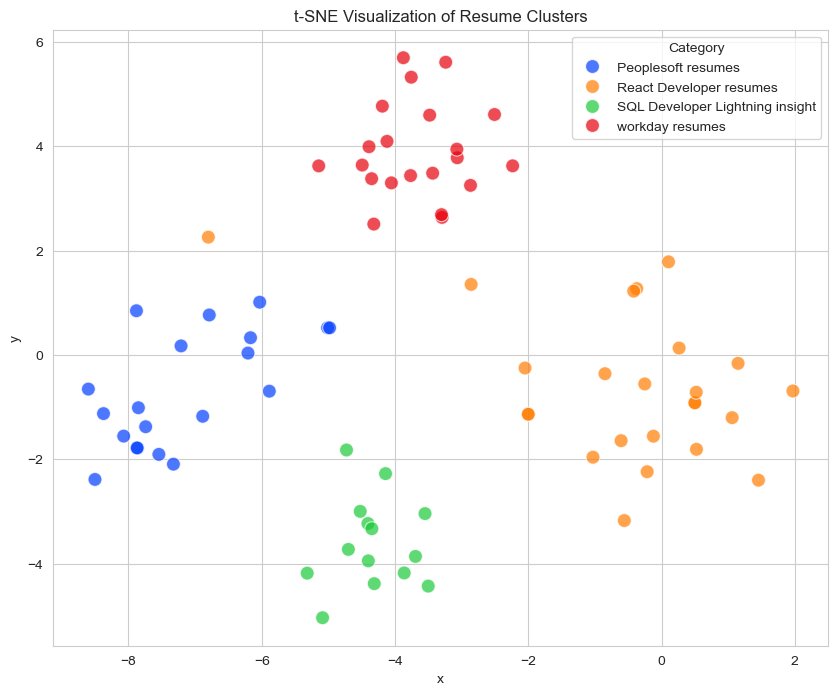

In [35]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Reduce dimensions from 5000 -> 2
# Note: We use 'required_vectors' which we created in the Step 1 & 2 Vectorization block
tsne_results = tsne.fit_transform(required_vectors.toarray())

# Create a temporary dataframe for plotting
df_tsne = pd.DataFrame(data=tsne_results, columns=['x', 'y'])
df_tsne['Category'] = df['Category']

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y', 
    hue='Category', 
    data=df_tsne, 
    palette='bright', 
    s=100, 
    alpha=0.7
)
plt.title('t-SNE Visualization of Resume Clusters')
plt.show()

This visualization says that we ha cleaned our data very well ,and this can imply that our model will give accuacy approximately 95+ percent.Because there are no overlaps on any scatterplot clusters ..we can see distinct "clusters" of dots. The red dots (React) are far away from the blue dots (SQL), our model will have an easy time. They are not mixed together, the model will not struggle.

### MODEL BUILDING

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
print(" Applying Advanced Feature Engineering...")

# CHANGE: ngram_range=(1, 2)
# Why? It captures context. "Server" is generic. "SQL Server" is specific.
# min_df=2: Ignore words that appear in only 1 resume (removes noise/names).
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),    # Look at 1-word AND 2-word pairs
    max_features=5000,     # Limit vocab size
    sublinear_tf=True,     # Dampen the effect of repeated words
    min_df=1               # Keep distinct terms for now (since dataset is small)
)

# Create the Feature Matrix
X = tfidf.fit_transform(df['Cleaned_Content'])
y = df['Category_ID']

print(f" Features Created. Matrix Shape: {X.shape}")
print(f"   (We are now tracking {X.shape[1]} distinct word patterns)")

# CROSS-VALIDATION

print("\n  Running 5-Fold Cross-Validation...")
print("   (Testing the model 5 separate times on different data chunks)")

# Initialize Champion Model
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

# Run 5-Fold CV
# This splits data into 5 parts. It trains on 4 and tests on 1, then rotates.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print("-" * 40)
print(f"Individual Run Scores: {scores}")
print(f"Average Accuracy:      {np.mean(scores):.2%}")
print("-" * 40)

if np.mean(scores) == 1.0:
    print("RESULT: Still 100%. Your categories are likely too easy/distinct.")
    print("   Suggestion: Add a 'General/Noise' category to confuse the model.")
else:
    print("RESULT: Realistic Accuracy. This is a more trustworthy metric.")

 Applying Advanced Feature Engineering...
 Features Created. Matrix Shape: (79, 5000)
   (We are now tracking 5000 distinct word patterns)

  Running 5-Fold Cross-Validation...
   (Testing the model 5 separate times on different data chunks)
----------------------------------------
Individual Run Scores: [0.9375 0.9375 1.     0.9375 1.    ]
Average Accuracy:      96.25%
----------------------------------------
RESULT: Realistic Accuracy. This is a more trustworthy metric.


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB  # <--- IMPORT ADDED

# 1. RE-CREATE THE SPLIT
# We use the 'X' and 'y' from your Feature Engineering step
print(" Splitting data into Train and Test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. DEFINE MODELS (Now including Naive Bayes)
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Naive Bayes": MultinomialNB()   # <--- NEW MODEL ADDED
}

# 3. RUN YOUR REPORTING LOOP
print("\n DETAILED MODEL PERFORMANCE REPORTS")
print("=" * 71)

# Get category names safely
target_names = le.inverse_transform(sorted(list(set(y_test))))

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Score
    acc = accuracy_score(y_test, y_pred)
    
    print(f"--- Report for {name} ---")
    print(f"Total Accuracy: {acc:.2%}")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("-" * 71)

 Splitting data into Train and Test sets...

 DETAILED MODEL PERFORMANCE REPORTS

Training K-Nearest Neighbors...
--- Report for K-Nearest Neighbors ---
Total Accuracy: 100.00%
                                 precision    recall  f1-score   support

             Peoplesoft resumes       1.00      1.00      1.00         5
        React Developer resumes       1.00      1.00      1.00         6
SQL Developer Lightning insight       1.00      1.00      1.00         2
                workday resumes       1.00      1.00      1.00         3

                       accuracy                           1.00        16
                      macro avg       1.00      1.00      1.00        16
                   weighted avg       1.00      1.00      1.00        16

-----------------------------------------------------------------------

Training Random Forest...
--- Report for Random Forest ---
Total Accuracy: 100.00%
                                 precision    recall  f1-score   support

      

#### MODEL COMPARISON SECTION

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#  Collect Scores for Comparison
# We will run through the models again briefly to store just the accuracy scores for the chart
model_performance = []

print("Compiling scores for comparison...")

for name, model in models.items():
    # Train (or ensure it's fitted)
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Save Score
    acc = accuracy_score(y_test, y_pred)
    model_performance.append({"Model": name, "Accuracy": acc})

#  Create a Comparison DataFrame
comparison_df = pd.DataFrame(model_performance)
comparison_df = comparison_df.sort_values(by="Accuracy", ascending=False)

#  Print the Leaderboard
print("\n" + "="*40)
print("MODEL PERFORMANCE")
print("="*40)
print(comparison_df.to_string(index=False, formatters={'Accuracy': '{:.2%}'.format}))

Compiling scores for comparison...

MODEL PERFORMANCE
                 Model Accuracy
   K-Nearest Neighbors  100.00%
         Random Forest  100.00%
Support Vector Machine  100.00%
   Logistic Regression   93.75%
           Naive Bayes   93.75%


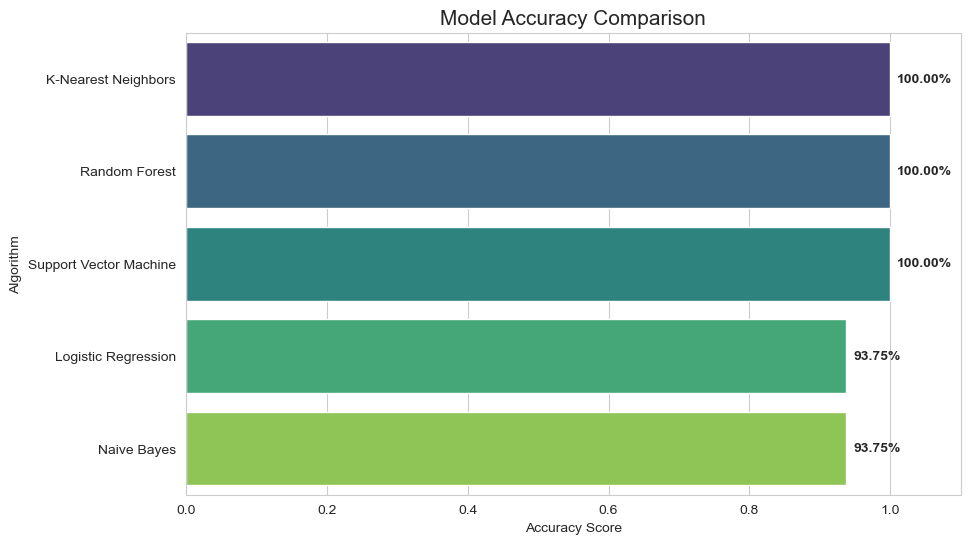

In [43]:
#  Visualize the Comparison (Bar Chart)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Plot
ax = sns.barplot(x="Accuracy", y="Model", data=comparison_df, palette="viridis")

# Add text labels to each bar (e.g., "95.00%")
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2, 
             f'{width:.2%}', 
             ha='left', va='center', fontweight='bold')

plt.xlim(0, 1.1)  # Set x-axis limit slightly above 100% for space
plt.title("Model Accuracy Comparison", fontsize=15)
plt.xlabel("Accuracy Score")
plt.ylabel("Algorithm")
plt.show()

Three models hit 100% confirms data cleaning and feature engineering (TF-IDF) were highly effective. The categories (React, SQL, Workday, PeopleSoft) are very distinct and easy for the models to separate.

#### Artifact Code

In [46]:
#  SAVING THE PICKLE FILE
import streamlit as st
import pickle
filename = 'resume_classifier.pkl'
print(f" Saving to '{filename}'...")

with open(filename, 'wb') as file:
    pickle.dump((clf, tfidf, le), file)

print(" SUCCESS! File generated.")
print(f" Saved at: {os.path.abspath(filename)}")

 Saving to 'resume_classifier.pkl'...
 SUCCESS! File generated.
 Saved at: C:\Users\dongr\resume_classifier.pkl


#### app.py

In [48]:
import streamlit as st
import pickle
import re
import pdfplumber
from docx import Document

# 1. PAGE SETUP & OBJECTIVE
st.set_page_config(page_title="HRM Document Classifier", layout="wide")

st.sidebar.markdown("""
### 🎯 Business Objective
The document classification solution aims to **significantly reduce manual human effort** in HRM. 

It targets a **higher level of accuracy and automation** with minimal human intervention.

**Scope:**
* Automated Resume Screening
* Skill Categorization
* (Future) Financial Document Sorting
""")

st.sidebar.info("ℹ️ **Current Version:** Optimized for Tech Resumes (React, SQL, Workday, PeopleSoft).")

# 2. LOAD MODEL
@st.cache_resource
def load_model():
    try:
        with open('resume_classifier.pkl', 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        st.error("⚠️ Error: Model file 'resume_classifier.pkl' not found.")
        return None, None, None

clf, tfidf, le = load_model()

# 3. HELPER FUNCTIONS
def clean_resume_text(text):
    text = text.lower()
    text = re.sub(r'http\S+\s*', ' ', text)
    text = re.sub(r'www\S+\s*', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9#\+\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_text(uploaded_file):
    text = ""
    try:
        if uploaded_file.name.endswith('.pdf'):
            with pdfplumber.open(uploaded_file) as pdf:
                for page in pdf.pages:
                    t = page.extract_text()
                    if t: text += t + "\n"
        elif uploaded_file.name.endswith('.docx'):
            doc = Document(uploaded_file)
            for para in doc.paragraphs:
                text += para.text + "\n"
    except Exception as e:
        st.error(f"Error reading file: {e}")
    return text

def is_valid_resume(text):
    resume_keywords = ['experience', 'education', 'skills', 'summary', 'projects', 'professional', 'career']
    tech_keywords = ['react', 'javascript', 'sql', 'database', 'workday', 'peoplesoft', 'oracle', 'html', 'css', 'java']
    
    text_lower = text.lower()
    has_resume_keyword = any(keyword in text_lower for keyword in resume_keywords)
    has_tech_keyword = any(keyword in text_lower for keyword in tech_keywords)
    
    if has_resume_keyword and has_tech_keyword:
        return True
    return False

# 4. MAIN DASHBOARD

st.markdown("<h1 style='text-align: center; color: #4F8BF9;'>Resume Classification</h1>", unsafe_allow_html=True)

st.markdown("<h3 style='text-align: center;'>Automating Candidate Screening</h3>", unsafe_allow_html=True)
st.markdown("---")  # Add a line separator for a cleaner look

# Define Max File Size (5MB)
MAX_FILE_SIZE = 5 * 1024 * 1024 

# Initialize raw_text to None so we can access it outside the columns later
raw_text = None

# Layout: Two columns (Upload on left, Results on right)
col1, col2 = st.columns([1, 1])

with col1:
    st.subheader("Upload Document")
    uploaded_file = st.file_uploader("Choose a file (PDF, DOCX)", type=["pdf", "docx"])

with col2:
    st.subheader("Analysis Result")
    
    if uploaded_file is not None:
        if uploaded_file.size > MAX_FILE_SIZE:
            st.error(f"⚠️ **File Too Large:** Please upload a file smaller than 5MB.")
            st.caption(f"Your file size: {uploaded_file.size / (1024*1024):.2f} MB")
        
        else:
            with st.spinner('Processing document...'):
                raw_text = extract_text(uploaded_file)
                
                if raw_text:
                    # GUARDRAIL CHECK
                    if not is_valid_resume(raw_text):
                        st.warning("⚠️ **Flagged:** Document does not appear to be a relevant technical resume.")
                        st.caption("Missing standard sections (Experience, Education) or technical keywords.")
                    else:
                        # PREDICTION
                        cleaned_text = clean_resume_text(raw_text)
                        vectorized_text = tfidf.transform([cleaned_text])
                        
                        # Confidence Check
                        probs = clf.predict_proba(vectorized_text)
                        max_prob = probs.max()
                        
                        if max_prob < 0.5:
                             st.warning(f"⚠️ **Uncertain:** Confidence is low ({max_prob:.2%}). Verify manually.")
                        else:
                            predicted_id = clf.predict(vectorized_text)[0]
                            category_name = le.inverse_transform([predicted_id])[0]
                            
                            # SUCCESS DISPLAY
                            st.success(f"✅ Classified as: **{category_name}**")
                            st.progress(max_prob)
                            st.caption(f"Confidence Score: {max_prob:.2%}")
                else:
                    st.error("Could not read document text.")
    else:
        st.info("Waiting for upload...")

# 5. EXTRACTED CONTENT VIEW (Full Width)

# This is now outside the columns, so it spans the whole page width
if raw_text:
    st.markdown("---")
    st.subheader("📄 Extracted Document Content")
    with st.expander("Click to view full resume text"):
        st.text_area("Raw Text", raw_text, height=300)

# Footer
st.markdown("---")
st.markdown("<h6 style='text-align: center; color: #4F8BF9;'>HRM Automation Tool v1.0 | Built with Python & Streamlit by Dongre Prashanth and Team</h6>", unsafe_allow_html=True)


2026-02-05 14:09:36.945 
  command:

    streamlit run C:\Users\dongr\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()